# Comparison of Profile Models

We sample two profile models:

1. The isolated profile model (reported)
2. The profile subcomponent of the full model

This notebook compares those two models to see what impact full-model training has on user inference.

## Setup

In [1]:
import os
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np
from scipy.special import expit, logit
from scipy import stats
import seaborn as sns
import plotnine as p
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kde import KDEUnivariate
import zarr
from IPython.display import display, Markdown

In [3]:
import bookgender.datatools as dt
from bookgender.nbutils import *

In [4]:
fig_dir = init_figs('ProfileModelCompare')

using figure dir figures/ProfileModelCompare


## Load Data

In [5]:
datasets = list(dt.datasets.keys())
datasets

['AZ', 'BX-E', 'BX-I', 'GR-E', 'GR-I']

In [6]:
def load(ds, model):
    _zf = zarr.ZipStore(f'data/{ds}/inference/{model}/samples.zarr', mode='r')
    _c = zarr.LRUStoreCache(_zf, 2**30)
    return zarr.group(_c)

In [7]:
p_samp = {}
f_samp = {}
for ds in datasets:
    p_samp[ds] = load(ds, 'profile')
    f_samp[ds] = load(ds, 'full')

## Compare Summary Parameters

The primary parameters of interest for profiles are $\mu$ and $\sigma$ - the mean and variance of the (log odds) proportions.

In [8]:
p_mu = pd.DataFrame(dict((ds, p_samp[ds]['mu']) for ds in datasets))
p_mu.index.name = 'Sample'
p_mu.describe()

,AZ,BX-E,BX-I,GR-E,GR-I
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.514382,-0.399709,-0.443828,-0.273208,-0.254363
std,0.029801,0.020151,0.017970,0.022427,0.021380
min,-0.618320,-0.470822,-0.512055,-0.366509,-0.349278
25%,-0.534410,-0.413218,-0.455956,-0.288445,-0.268497
50%,-0.514355,-0.399837,-0.443576,-0.273294,-0.254363
75%,-0.494401,-0.386026,-0.431779,-0.258152,-0.239769
max,-0.407880,-0.317007,-0.374692,-0.187482,-0.152170


In [9]:
f_mu = pd.DataFrame(dict((ds, f_samp[ds]['mu']) for ds in datasets))
f_mu.index.name = 'Sample'
f_mu.describe()

,AZ,BX-E,BX-I,GR-E,GR-I
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.422042,-0.386132,-0.434960,-0.267217,-0.244974
std,0.027193,0.020111,0.016926,0.022540,0.019699
min,-0.529776,-0.465225,-0.499783,-0.352164,-0.315294
25%,-0.439871,-0.399545,-0.446454,-0.282246,-0.258416
50%,-0.421924,-0.386269,-0.435103,-0.267251,-0.244704
75%,-0.403800,-0.372363,-0.423487,-0.252198,-0.231755
max,-0.312990,-0.314502,-0.368429,-0.189616,-0.165044


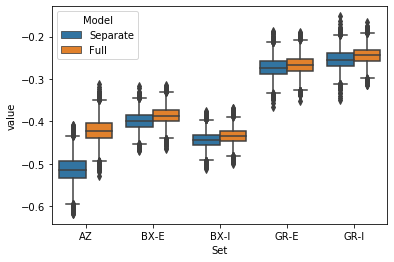

In [10]:
mu = pd.concat({'Separate': p_mu, 'Full': f_mu}, names=['Model']).reset_index()
mu = mu.melt(id_vars=['Model', 'Sample'], var_name='Set')
sns.boxplot('Set', 'value', hue='Model', data=mu)

In [11]:
p_s = pd.DataFrame(dict((ds, p_samp[ds]['sigma']) for ds in datasets))
p_s.index.name = 'Sample'
p_s.describe()

,AZ,BX-E,BX-I,GR-E,GR-I
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.875013,1.185160,1.083392,1.498967,1.444597
std,0.029923,0.018733,0.017045,0.017982,0.016511
min,1.755840,1.108950,1.008110,1.433390,1.381690
25%,1.854365,1.172610,1.071810,1.486530,1.433578
50%,1.874700,1.185165,1.083350,1.498410,1.444095
75%,1.894970,1.197460,1.094915,1.510945,1.455522
max,2.008700,1.257240,1.146390,1.568860,1.513180


In [12]:
f_s = pd.DataFrame(dict((ds, f_samp[ds]['sigma']) for ds in datasets))
f_s.index.name = 'Sample'
f_s.describe()

,AZ,BX-E,BX-I,GR-E,GR-I
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.743360,1.206495,1.073051,1.511378,1.371841
std,0.024639,0.018816,0.014803,0.018005,0.014597
min,1.652220,1.139190,1.017560,1.445010,1.316520
25%,1.726837,1.193845,1.063130,1.499287,1.362078
50%,1.743105,1.206190,1.073090,1.511300,1.371835
75%,1.759890,1.219172,1.082910,1.523432,1.381490
max,1.824560,1.285000,1.125910,1.577510,1.428880


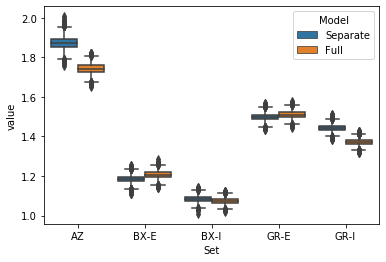

In [13]:
sigma = pd.concat({'Separate': p_s, 'Full': f_s}, names=['Model']).reset_index()
sigma = sigma.melt(id_vars=['Model', 'Sample'], var_name='Set')
sns.boxplot('Set', 'value', hue='Model', data=sigma)

## Comparing Projected Values

Let's now compare the $\theta$ values - what does each model predict for the distribution of user profile tendencies?

In [14]:
p_th = pd.DataFrame(dict((ds, p_samp[ds]['thetaP']) for ds in datasets))
p_th.index.name = 'Sample'
p_th.describe()

,AZ,BX-E,BX-I,GR-E,GR-I
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.416734,0.422535,0.412365,0.452728,0.451432
std,0.299767,0.229406,0.216790,0.269713,0.262539
min,0.000527,0.007993,0.009984,0.002151,0.004607
25%,0.139004,0.232165,0.237363,0.216333,0.224470
50%,0.370690,0.402033,0.387333,0.436360,0.433280
75%,0.675581,0.597704,0.572539,0.677640,0.666217
max,0.998827,0.981249,0.975965,0.997260,0.994236


In [15]:
f_th = pd.DataFrame(dict((ds, f_samp[ds]['thetaP']) for ds in datasets))
f_th.index.name = 'Sample'
f_th.describe()

,AZ,BX-E,BX-I,GR-E,GR-I
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.429019,0.427444,0.411889,0.451355,0.458319
std,0.289965,0.233149,0.212814,0.270317,0.257499
min,0.001118,0.008927,0.012457,0.002978,0.003469
25%,0.170024,0.233544,0.238614,0.214576,0.240607
50%,0.392241,0.408919,0.392352,0.429607,0.439171
75%,0.676072,0.607898,0.569449,0.681477,0.667624
max,0.996645,0.982007,0.982311,0.994626,0.992481


In [16]:
thetaP = pd.concat({'Separate': p_th, 'Full': f_th}, names=['Model']).reset_index()
thetaP = thetaP.melt(id_vars=['Model', 'Sample'], var_name='Set')

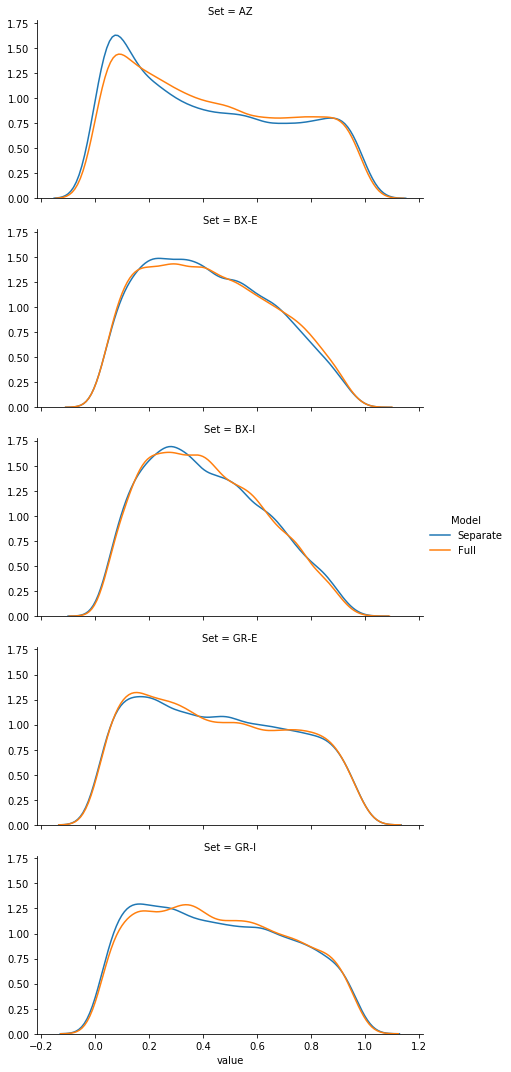

In [17]:
grid = sns.FacetGrid(row='Set', hue='Model', data=thetaP, aspect=2)
grid.map(sns.kdeplot, 'value')
grid.add_legend()

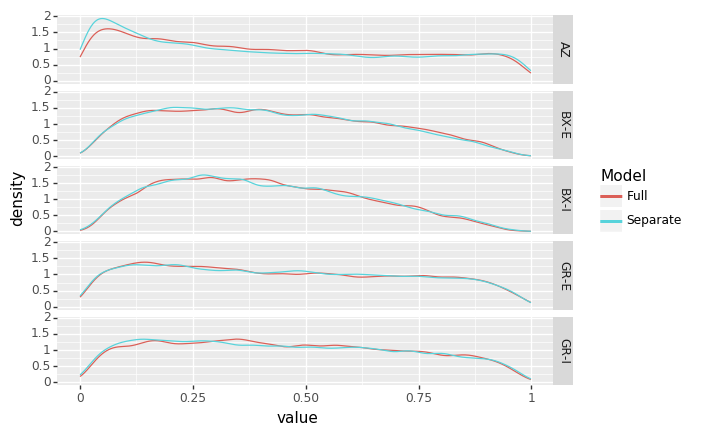

<ggplot: (8781259350597)>

In [18]:
(pn.ggplot(thetaP, pn.aes('value', color='Model')) 
 + pn.geom_line(stat='density', adjust=0.5)
 + pn.facet_grid('Set ~'))

## Individual User Thetas

Now let's look at individual user's estimated theta values. How different are they?  We will start by loading each user's posterior expected $\theta_u$ - by linearity of expectation, the expected difference is the difference in expected values.

In [19]:
p_thu = pd.concat(dict(
    (ds, pd.DataFrame({'nTheta': np.mean(p_samp[ds]['nTheta'], axis=0)}))
    for ds in datasets
), names=['Set', 'User'])
p_thu['Theta'] = expit(p_thu['nTheta'])
p_thu

nTheta     Theta
Set  User                    
AZ   0     1.059797  0.742652
     1    -0.936946  0.281518
     2    -2.645083  0.066293
     3    -1.533403  0.177496
     4    -2.658765  0.065451
...             ...       ...
GR-I 4995  1.067174  0.744059
     4996 -1.543224  0.176067
     4997 -0.918932  0.285175
     4998  1.510817  0.819182
     4999 -2.024523  0.116652

[25000 rows x 2 columns]

In [20]:
f_thu = pd.concat(dict(
    (ds, pd.DataFrame({'nTheta': np.mean(f_samp[ds]['nTheta'], axis=0)}))
    for ds in datasets
), names=['Set', 'User'])
f_thu['Theta'] = expit(f_thu['nTheta'])
f_thu

nTheta     Theta
Set  User                    
AZ   0     1.271355  0.780975
     1    -0.704679  0.330776
     2    -2.010412  0.118114
     3    -2.480734  0.077220
     4    -1.701148  0.154315
...             ...       ...
GR-I 4995  1.089918  0.748366
     4996 -1.428438  0.193342
     4997 -0.878642  0.293459
     4998  1.544678  0.824144
     4999 -2.015445  0.117591

[25000 rows x 2 columns]

In [21]:
thetaU = p_thu.join(f_thu, rsuffix='_f')
thetaU['ndiff'] = thetaU['nTheta_f'] - thetaU['nTheta']
thetaU['diff'] = thetaU['Theta_f'] - thetaU['Theta']
thetaU.describe()

,nTheta,Theta,nTheta_f,Theta_f,ndiff,diff
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,-0.377055,0.425650,-0.351105,0.426963,0.025950,0.001312
std,1.310954,0.245157,1.343335,0.247269,0.442744,0.073400
min,-4.611648,0.009838,-4.463211,0.011394,-3.004567,-0.591574
25%,-1.302338,0.213772,-1.274608,0.218470,-0.128474,-0.021950
50%,-0.409445,0.399045,-0.403842,0.400390,0.002216,0.000395
75%,0.411312,0.601402,0.414463,0.602157,0.165283,0.026456
max,5.259550,0.994829,5.000654,0.993311,3.257669,0.652368


In [22]:
thetaU['diff'].quantile([0.025, 0.975])

0.025   -0.167280
0.975    0.161608
Name: diff, dtype: float64

In [23]:
thetaU['diff'].abs().describe()

count    2.500000e+04
mean     4.549474e-02
std      5.761476e-02
min      2.054315e-07
25%      7.668859e-03
50%      2.407147e-02
75%      6.075029e-02
max      6.523681e-01
Name: diff, dtype: float64

95%ile?

In [24]:
thetaU['diff'].abs().quantile(0.95)

0.16448341395008292

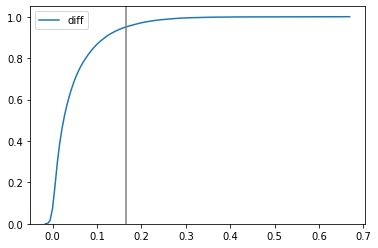

In [25]:
sns.kdeplot(thetaU['diff'].abs(), cumulative=True)
plt.axvline(thetaU['diff'].abs().quantile(0.95), color='grey')

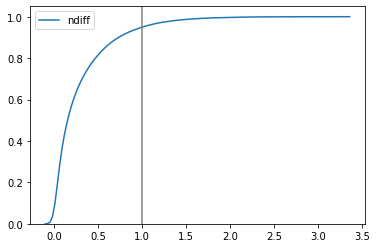

In [26]:
sns.kdeplot(thetaU['ndiff'].abs(), cumulative=True)
plt.axvline(thetaU['ndiff'].abs().quantile(0.95), color='grey')